## Plant Seedling Classification Notebook
### Import Dataset

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train and validation datasets
breed_path = "plant/train/"
valid_path = "plant/valid/"

def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return plant_files, plant_targets

# load train and validation datasets
train_files, train_targets = load_dataset(breed_path)
valid_files, valid_targets = load_dataset(valid_path)


# load list of plant names
plant_names = [item[28:-1] for item in sorted(glob(breed_path+"*/"))]

# print statistics about the dataset
print('There are %d total plant categories.' % len(plant_names))
print('There are %d training plant images.' % len(train_files))
print('There are %d validation plant images.' % len(valid_files))

There are 12 total plant categories.
There are 3801 training plant images.
There are 949 validation plant images.


### Pre-process the Data

In [2]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from tqdm import tqdm
from PIL import ImageFile    


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(299, 299))
    # convert PIL.Image.Image type to 3D tensor with shape (299, 299, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 299, 299, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the train data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████| 3801/3801 [01:57<00:00, 32.26it/s]


In [3]:
# pre-process the validation data for Keras
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 949/949 [00:19<00:00, 47.81it/s]


### Data Exploration

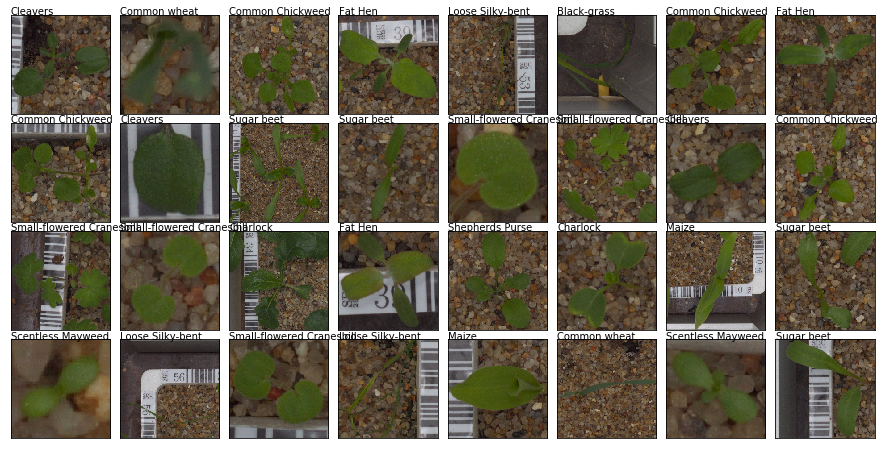

In [75]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 12))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.1)

for i in range(32):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(train_tensors[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 0,plant_names[np.argmax(train_targets[i])])

In [72]:
# value count of each class in the train dataset
import os
value_count = {}
for i in plant_names:
    count = len(os.listdir(breed_path+i))
    dash = "-" * (30-len(i))
    value_count[i] = count
    print(i +dash+ str(count))

Black-grass-------------------210
Charlock----------------------312
Cleavers----------------------230
Common Chickweed--------------489
Common wheat------------------177
Fat Hen-----------------------380
Loose Silky-bent--------------523
Maize-------------------------177
Scentless Mayweed-------------413
Shepherds Purse---------------185
Small-flowered Cranesbill-----397
Sugar beet--------------------308


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

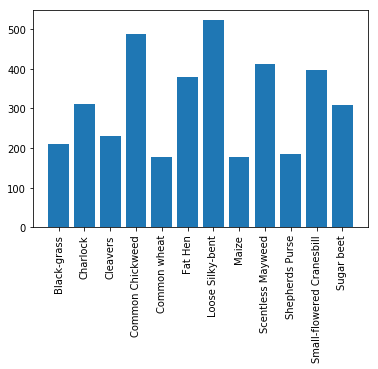

In [73]:
# a bar chart plot of the value count of each class in the train dataset 
%matplotlib inline
plt.bar(value_count.keys(), value_count.values())
plt.xticks(rotation=90)

### Model Architecture

In [4]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

def get_model(base_model, optimizer, index=None):
    if index is None:
        # freeze all the layers of the base model
        for layer in base_model.layers:
            layer.trainable = False
    else:
        # the index specifies the number of layers to train
        for layer in base_model.layers[:-index]:
            layer.trainable = False

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer with 12 classes
    predictions = Dense(12, activation='softmax')(x)

    # this is the model we will train based on the base model inputed
    model = Model(inputs=base_model.input, outputs=predictions)


    # compile the model 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # return the model
    return model


In [5]:
# this defines the path to save the best model
from keras.callbacks import ModelCheckpoint
def get_model_checkpoint(path):
    checkpointer = ModelCheckpoint(filepath=path, verbose=1, save_best_only=True)
    return checkpointer

### Image Augmentation
As a result of low memory space, the zca_whitening could not be fitted with the data.

In [13]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(zca_whitening=True,
                         horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         rotation_range = 30
                        )
# gen.fit(train_tensors)

/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


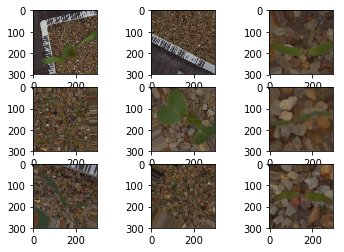

In [24]:
for X_batch, y_batch in gen.flow(train_tensors, train_targets, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

## Training a CNN model using transfer learning
### Training an InceptionResNetV2 model
A pretrained InceptionResNetV2 model will be used, with all its layers frozen, except the top classification layer which is fine-tuned to have 12 nodes, each representing each class in the dataset. No image augmentation is applied to this model.

In [24]:
# call the get_model_checkpoint and the get_model functions
checkpointer = get_model_checkpoint('saved_models/weights.incepresneet_rmsprop2.from_scratch.hdf5')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop')

# fit the model
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=16, batch_size=32, callbacks=[checkpointer], verbose=1)
    
# evaluate the model
scores = model.evaluate(valid_tensors, valid_targets, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 3801 samples, validate on 949 samples
Epoch 1/16
3801/3801 [==============================] - 233s 61ms/step - loss: 1.7817 - acc: 0.4491 - val_loss: 1.4252 - val_acc: 0.5290
Epoch 2/16
3801/3801 [==============================] - 132s 35ms/step - loss: 1.2060 - acc: 0.6601 - val_loss: 1.1383 - val_acc: 0.6270
Epoch 3/16
3801/3801 [==============================] - 132s 35ms/step - loss: 0.9802 - acc: 0.7088 - val_loss: 1.0250 - val_acc: 0.6639
Epoch 4/16
3801/3801 [==============================] - 131s 35ms/step - loss: 0.8530 - acc: 0.7490 - val_loss: 0.8645 - val_acc: 0.7281
Epoch 5/16
3801/3801 [==============================] - 131s 35ms/step - loss: 0.7647 - acc: 0.7753 - val_loss: 0.8355 - val_acc: 0.7376
Epoch 6/16
3801/3801 [==============================] - 131s 35ms/step - loss: 0.7150 - acc: 0.7880 - val_loss: 0.7698 - val_acc: 0.7534
Epoch 7/16
3801/3801 [==============================] - 131s 35ms/step - loss: 0.6533 - acc: 0.8061 - val_loss: 0.7290 - val_acc: 0

In [8]:
from sklearn.metrics import f1_score
model.load_weights('saved_models/weights.incepresneet_rmsprop2.from_scratch.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 80.1897%, f1 score: 0.8019


#### Since the dataset is not balance, the weights of each class will be slightly modified in order for the model to pay attention to the minority class. The accuracy gotten is 80.61% and this is slightly better than the previous model.

In [8]:
# call the get_model_checkpoint and the get_model functions
checkpointer = get_model_checkpoint('saved_models/weights.incepresneet_rmsprop3.from_scratch.hdf5')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop')

#fit the model
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
          epochs=16, batch_size=32, callbacks=[checkpointer], verbose=1)
    
# evaluate the model
scores = model.evaluate(valid_tensors, valid_targets, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 3801 samples, validate on 949 samples
Epoch 1/16
3801/3801 [==============================] - 164s 43ms/step - loss: 3.0815 - acc: 0.4309 - val_loss: 1.4193 - val_acc: 0.5353
Epoch 2/16
3801/3801 [==============================] - 131s 35ms/step - loss: 2.0762 - acc: 0.6430 - val_loss: 1.1606 - val_acc: 0.6238
Epoch 3/16
3801/3801 [==============================] - 131s 34ms/step - loss: 1.6852 - acc: 0.7024 - val_loss: 1.0015 - val_acc: 0.7018
Epoch 4/16
3801/3801 [==============================] - 131s 34ms/step - loss: 1.4450 - acc: 0.7356 - val_loss: 0.8859 - val_acc: 0.7334
Epoch 5/16
3801/3801 [==============================] - 131s 34ms/step - loss: 1.3048 - acc: 0.7640 - val_loss: 0.8439 - val_acc: 0.7429
Epoch 6/16
3801/3801 [==============================] - 131s 34ms/step - loss: 1.2241 - acc: 0.7706 - val_loss: 0.7846 - val_acc: 0.7555
Epoch 7/16
3801/3801 [==============================] - 131s 34ms/step - loss: 1.1170 - acc: 0.7914 - val_loss: 0.7363 - val_acc: 0

#### In the cell below, the optimizer is changed from 'rmsprop' to 'adam' and this gives an accuracy of 79.24% which is less than the accuracy gotten when an 'rmsprop' optimizer is used. 

In [12]:
# call the get_model_checkpoint and the get_model functions
checkpointer = get_model_checkpoint('saved_models/weights.incepresneet_rmsprop3.from_scratch.hdf5')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
model = get_model(base_model, 'adam')

# fit the model
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
          epochs=16, batch_size=32, callbacks=[checkpointer], verbose=1)
    
# evaluate the model
scores = model.evaluate(valid_tensors, valid_targets, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 3801 samples, validate on 949 samples
Epoch 1/16
3801/3801 [==============================] - 233s 61ms/step - loss: 3.0667 - acc: 0.4454 - val_loss: 1.3583 - val_acc: 0.5606
Epoch 2/16
3801/3801 [==============================] - 132s 35ms/step - loss: 2.0486 - acc: 0.6622 - val_loss: 1.1194 - val_acc: 0.6554
Epoch 3/16
3801/3801 [==============================] - 132s 35ms/step - loss: 1.6603 - acc: 0.7251 - val_loss: 0.9859 - val_acc: 0.7050
Epoch 4/16
3801/3801 [==============================] - 132s 35ms/step - loss: 1.4596 - acc: 0.7582 - val_loss: 0.9231 - val_acc: 0.7123
Epoch 5/16
3801/3801 [==============================] - 133s 35ms/step - loss: 1.3146 - acc: 0.7758 - val_loss: 0.8888 - val_acc: 0.7313
Epoch 6/16
3801/3801 [==============================] - 133s 35ms/step - loss: 1.2172 - acc: 0.7814 - val_loss: 0.8139 - val_acc: 0.7555
Epoch 7/16
3801/3801 [==============================] - 133s 35ms/step - loss: 1.1399 - acc: 0.7919 - val_loss: 0.7697 - val_acc: 0

In [9]:
from sklearn.metrics import f1_score
model.load_weights('saved_models/weights.incepresneet_rmsprop3.from_scratch.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 79.2413%, f1 score: 0.7924


#### Image augmentation is implemented in the code cell below. The top 3 layers of the InceptionResNetV2 model were unfrozen and trained. This yielded an accuracy of 88.0927% and an f1 score of 0.8809

In [8]:
# call the get_model_checkpoint and the get_model functions
generator = gen.flow(train_tensors, train_targets, batch_size = 32, seed=0)
checkpointer = get_model_checkpoint('saved_models/weights.incepresneet_rmsprop3.from_scratch.hdf5')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop', 3)

# fit the model
model.fit_generator(
                generator,
                steps_per_epoch=119.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

219062272/219055592 [==============================] - 4s 0us/step
Epoch 1/16


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


119/119 [==============================] - 147s 1s/step - loss: 1.3918 - acc: 0.7229 - val_loss: 1.0161 - val_acc: 0.6765
Epoch 2/16
119/119 [==============================] - 128s 1s/step - loss: 0.7448 - acc: 0.8442 - val_loss: 0.6268 - val_acc: 0.7945
Epoch 3/16
119/119 [==============================] - 127s 1s/step - loss: 0.5865 - acc: 0.8700 - val_loss: 0.5780 - val_acc: 0.7977
Epoch 4/16
119/119 [==============================] - 125s 1s/step - loss: 0.5066 - acc: 0.8823 - val_loss: 0.6072 - val_acc: 0.7998
Epoch 5/16
119/119 [==============================] - 125s 1s/step - loss: 0.4843 - acc: 0.8867 - val_loss: 0.6312 - val_acc: 0.8124
Epoch 6/16
119/119 [==============================] - 127s 1s/step - loss: 0.4280 - acc: 0.8989 - val_loss: 0.4446 - val_acc: 0.8493
Epoch 7/16
119/119 [==============================] - 127s 1s/step - loss: 0.4118 - acc: 0.9069 - val_loss: 0.4127 - val_acc: 0.8662
Epoch 8/16
119/119 [==============================] - 125s 1s/step - loss: 0.362

In [10]:
from sklearn.metrics import f1_score
model.load_weights('saved_models/weights.incepresneet_rmsprop3.from_scratch.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 88.0927%, f1 score: 0.8809


#### In the code cell below, the batch size was changed from 32 to 64 and this increased the accuracy of the model, from 88.0927% to 89.0411%

In [11]:
# call the get_model_checkpoint and the get_model functions
generator = gen.flow(train_tensors, train_targets, batch_size = 64, seed=0)
checkpointer = get_model_checkpoint('saved_models/weights.incepresneet_rmsprop2.from_scratch.hdf5')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop', 3)

# fit the model
model.fit_generator(
                generator,
                steps_per_epoch=59.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

Epoch 1/16


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


59/59 [==============================] - 159s 3s/step - loss: 1.5346 - acc: 0.7006 - val_loss: 0.9764 - val_acc: 0.6807
Epoch 2/16
59/59 [==============================] - 117s 2s/step - loss: 0.7358 - acc: 0.8428 - val_loss: 0.7361 - val_acc: 0.7471
Epoch 3/16
59/59 [==============================] - 116s 2s/step - loss: 0.5757 - acc: 0.8782 - val_loss: 0.6381 - val_acc: 0.7850
Epoch 4/16
59/59 [==============================] - 115s 2s/step - loss: 0.4833 - acc: 0.8962 - val_loss: 0.7759 - val_acc: 0.7524
Epoch 5/16
59/59 [==============================] - 116s 2s/step - loss: 0.4454 - acc: 0.8989 - val_loss: 0.5419 - val_acc: 0.8188
Epoch 6/16
59/59 [==============================] - 115s 2s/step - loss: 0.3820 - acc: 0.9122 - val_loss: 0.5720 - val_acc: 0.7935
Epoch 7/16
59/59 [==============================] - 117s 2s/step - loss: 0.3805 - acc: 0.9137 - val_loss: 0.5259 - val_acc: 0.8156
Epoch 8/16
59/59 [==============================] - 115s 2s/step - loss: 0.3524 - acc: 0.9198 

In [10]:
model.load_weights('saved_models/weights.incepresneet_rmsprop2.from_scratch.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 89.0411%, f1 score: 0.8904


#### Using an 'adam' optimizer, with a batch size of 64, and training the last 3 layers of the InceptionResNetV2 model, the accuracy gotten is not as high as the accuracy gotten when an 'rmsprop' optimizer is used.

In [11]:
# call the get_model_checkpoint and the get_model functions
generator = gen.flow(train_tensors, train_targets, batch_size = 64, seed=0)
checkpointer = get_model_checkpoint('saved_models/weights.incepresneet.hdf5')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
model = get_model(base_model, 'adam', 3)

# fit the model
model.fit_generator(
                generator,
                steps_per_epoch=59.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

Epoch 1/16


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


59/59 [==============================] - 156s 3s/step - loss: 1.5818 - acc: 0.6794 - val_loss: 1.1447 - val_acc: 0.6228
Epoch 2/16
59/59 [==============================] - 117s 2s/step - loss: 0.7122 - acc: 0.8490 - val_loss: 0.6844 - val_acc: 0.7566
Epoch 3/16
59/59 [==============================] - 117s 2s/step - loss: 0.5533 - acc: 0.8893 - val_loss: 0.6407 - val_acc: 0.7629
Epoch 4/16
59/59 [==============================] - 117s 2s/step - loss: 0.4765 - acc: 0.8949 - val_loss: 0.4297 - val_acc: 0.8451
Epoch 5/16
59/59 [==============================] - 115s 2s/step - loss: 0.4232 - acc: 0.9130 - val_loss: 0.4363 - val_acc: 0.8335
Epoch 6/16
59/59 [==============================] - 115s 2s/step - loss: 0.3635 - acc: 0.9175 - val_loss: 0.4547 - val_acc: 0.8388
Epoch 7/16
59/59 [==============================] - 117s 2s/step - loss: 0.3465 - acc: 0.9255 - val_loss: 0.3846 - val_acc: 0.8588
Epoch 8/16
59/59 [==============================] - 117s 2s/step - loss: 0.3220 - acc: 0.9263 

In [13]:
model.load_weights('saved_models/weights.incepresneet.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 87.5659%, f1 score: 0.8757


#### Using an 'adam' optimizer, with a batch size of 32, and training the last 3 layers of the InceptionResNetV2 model, the accuracy gotten is not as high as the accuracy gotten when an 'rmsprop' optimizer is used.

In [14]:
generator = gen.flow(train_tensors, train_targets, batch_size = 32, seed=0)

checkpointer = get_model_checkpoint('saved_models/weights.incepresneet.hdf5')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
model = get_model(base_model, 'adam', 3)
model.fit_generator(
                generator,
                steps_per_epoch=119.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

Epoch 1/16


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


119/119 [==============================] - 187s 2s/step - loss: 1.4708 - acc: 0.7011 - val_loss: 0.7664 - val_acc: 0.7334
Epoch 2/16
119/119 [==============================] - 127s 1s/step - loss: 0.6864 - acc: 0.8456 - val_loss: 0.7967 - val_acc: 0.7313
Epoch 3/16
119/119 [==============================] - 129s 1s/step - loss: 0.5573 - acc: 0.8803 - val_loss: 0.6288 - val_acc: 0.7808
Epoch 4/16
119/119 [==============================] - 128s 1s/step - loss: 0.4948 - acc: 0.8857 - val_loss: 0.5166 - val_acc: 0.8124
Epoch 5/16
119/119 [==============================] - 127s 1s/step - loss: 0.4768 - acc: 0.8966 - val_loss: 0.6925 - val_acc: 0.7692
Epoch 6/16
119/119 [==============================] - 127s 1s/step - loss: 0.4102 - acc: 0.9033 - val_loss: 0.5170 - val_acc: 0.8261
Epoch 7/16
119/119 [==============================] - 129s 1s/step - loss: 0.3987 - acc: 0.9076 - val_loss: 0.4455 - val_acc: 0.8409
Epoch 8/16
119/119 [==============================] - 127s 1s/step - loss: 0.335

In [15]:
model.load_weights('saved_models/weights.incepresneet.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 86.5121%, f1 score: 0.8651


#### With the above cell codes, it's concluded that the rmsprop optimizer is best for this project. 
#### Using an 'rmsprop' optimizer, with a batch size of 64 and training the last 5 layers of the InceptionResNetV2 model, the accuracy gotten is less than the accuracy gotten when the last 3 layers of the  InceptionResNetV2 model was unfrozen.

In [16]:
# call the get_model_checkpoint and the get_model functions
generator = gen.flow(train_tensors, train_targets, batch_size = 64, seed=0)
checkpointer = get_model_checkpoint('saved_models/weights.incepresneet.hdf5')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop', 5)

# fit the model
model.fit_generator(
                generator,
                steps_per_epoch=59.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

Epoch 1/16


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


59/59 [==============================] - 205s 3s/step - loss: 1.4696 - acc: 0.7097 - val_loss: 1.5475 - val_acc: 0.5522
Epoch 2/16
59/59 [==============================] - 118s 2s/step - loss: 0.7710 - acc: 0.8342 - val_loss: 1.0563 - val_acc: 0.6607
Epoch 3/16
59/59 [==============================] - 119s 2s/step - loss: 0.6206 - acc: 0.8673 - val_loss: 0.7910 - val_acc: 0.7460
Epoch 4/16
59/59 [==============================] - 118s 2s/step - loss: 0.5128 - acc: 0.8903 - val_loss: 0.6184 - val_acc: 0.7777
Epoch 5/16
59/59 [==============================] - 118s 2s/step - loss: 0.4971 - acc: 0.8897 - val_loss: 0.5917 - val_acc: 0.8051
Epoch 6/16
59/59 [==============================] - 117s 2s/step - loss: 0.4493 - acc: 0.9036 - val_loss: 0.8261 - val_acc: 0.7408
Epoch 7/16
59/59 [==============================] - 119s 2s/step - loss: 0.4195 - acc: 0.9000 - val_loss: 0.4434 - val_acc: 0.8493
Epoch 8/16
59/59 [==============================] - 118s 2s/step - loss: 0.3857 - acc: 0.9150 

In [17]:
model.load_weights('saved_models/weights.incepresneet.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 84.9315%, f1 score: 0.8493


### Training an Xception model 
#### The cell below trains the top 3 layers of an Xception model and a validation accuracy of 87.8820% was derived.

In [19]:
from keras.applications.xception import Xception

# call the get_model_checkpoint and the get_model functions
generator = gen.flow(train_tensors, train_targets, batch_size = 64, seed=0)
checkpointer = get_model_checkpoint('saved_models/weights.xception.hdf5')
base_model = Xception(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop', 3)

# fit the model
model.fit_generator(
                generator,
                steps_per_epoch=59.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

83689472/83683744 [==============================] - 2s 0us/step
Epoch 1/16


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


59/59 [==============================] - 111s 2s/step - loss: 1.5207 - acc: 0.7152 - val_loss: 0.9985 - val_acc: 0.6544
Epoch 2/16
59/59 [==============================] - 89s 2s/step - loss: 0.7475 - acc: 0.8483 - val_loss: 0.7160 - val_acc: 0.7682
Epoch 3/16
59/59 [==============================] - 88s 1s/step - loss: 0.6053 - acc: 0.8695 - val_loss: 0.5701 - val_acc: 0.8114
Epoch 4/16
59/59 [==============================] - 88s 1s/step - loss: 0.5077 - acc: 0.8855 - val_loss: 0.4783 - val_acc: 0.8303
Epoch 5/16
59/59 [==============================] - 89s 2s/step - loss: 0.4485 - acc: 0.9005 - val_loss: 0.4390 - val_acc: 0.8367
Epoch 6/16
59/59 [==============================] - 88s 1s/step - loss: 0.4072 - acc: 0.9050 - val_loss: 0.4569 - val_acc: 0.8546
Epoch 7/16
59/59 [==============================] - 89s 2s/step - loss: 0.3674 - acc: 0.9128 - val_loss: 0.4257 - val_acc: 0.8662
Epoch 8/16
59/59 [==============================] - 88s 1s/step - loss: 0.3469 - acc: 0.9212 - val_l

In [21]:
model.load_weights('saved_models/weights.xception.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 87.8820%, f1 score: 0.8788


#### Using a batch size of 32, a lower accuracy was gotten. 

In [24]:
# call the get_model_checkpoint and the get_model functions
generator = gen.flow(train_tensors, train_targets, batch_size = 32, seed=0)
checkpointer = get_model_checkpoint('saved_models/weights.xception.hdf5')
base_model = Xception(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop', 3)

# fit the model
model.fit_generator(
                generator,
                steps_per_epoch=119.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

Epoch 1/16


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


119/119 [==============================] - 117s 987ms/step - loss: 1.3977 - acc: 0.7337 - val_loss: 0.7653 - val_acc: 0.7471
Epoch 2/16
119/119 [==============================] - 91s 768ms/step - loss: 0.7422 - acc: 0.8423 - val_loss: 0.5877 - val_acc: 0.8030
Epoch 3/16
119/119 [==============================] - 91s 767ms/step - loss: 0.5836 - acc: 0.8668 - val_loss: 0.5148 - val_acc: 0.8398
Epoch 4/16
119/119 [==============================] - 91s 766ms/step - loss: 0.5352 - acc: 0.8800 - val_loss: 0.4498 - val_acc: 0.8577
Epoch 5/16
119/119 [==============================] - 91s 767ms/step - loss: 0.4916 - acc: 0.8978 - val_loss: 0.5132 - val_acc: 0.8282
Epoch 6/16
119/119 [==============================] - 92s 772ms/step - loss: 0.4455 - acc: 0.9008 - val_loss: 0.4453 - val_acc: 0.8609
Epoch 7/16
119/119 [==============================] - 91s 767ms/step - loss: 0.4581 - acc: 0.8966 - val_loss: 0.4806 - val_acc: 0.8641
Epoch 8/16
119/119 [==============================] - 91s 768ms/s

In [25]:
model.load_weights('saved_models/weights.xception.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 86.4067%, f1 score: 0.8641


In [4]:
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         rotation_range = 30)

#### The code cell below trains the top 6 layers of an xception model with a 64 batch size. A much higher accuracy was derived.

In [9]:
# call the get_model_checkpoint and the get_model functions
generator = gen.flow(train_tensors, train_targets, batch_size = 64, seed=0)
checkpointer = get_model_checkpoint('saved_models/weights.xception.hdf5')
base_model = Xception(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop', 6)

# fit the model
model.fit_generator(
                generator,
                steps_per_epoch=59.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

83689472/83683744 [==============================] - 2s 0us/step
Epoch 1/16
59/59 [==============================] - 97s 2s/step - loss: 1.0910 - acc: 0.7740 - val_loss: 1.1153 - val_acc: 0.6955
Epoch 2/16
59/59 [==============================] - 92s 2s/step - loss: 0.4936 - acc: 0.8907 - val_loss: 0.6372 - val_acc: 0.8209
Epoch 3/16
59/59 [==============================] - 92s 2s/step - loss: 0.4590 - acc: 0.8968 - val_loss: 0.5948 - val_acc: 0.8430
Epoch 4/16
59/59 [==============================] - 92s 2s/step - loss: 0.3366 - acc: 0.9212 - val_loss: 0.5023 - val_acc: 0.8546
Epoch 5/16
59/59 [==============================] - 92s 2s/step - loss: 0.3118 - acc: 0.9281 - val_loss: 0.4359 - val_acc: 0.8736
Epoch 6/16
59/59 [==============================] - 92s 2s/step - loss: 0.2710 - acc: 0.9363 - val_loss: 0.5478 - val_acc: 0.8599
Epoch 7/16
59/59 [==============================] - 93s 2s/step - loss: 0.2355 - acc: 0.9473 - val_loss: 0.4275 - val_acc: 0.8978
Epoch 8/16
59/59 [=======

In [11]:
from sklearn.metrics import f1_score
model.load_weights('saved_models/weights.xception.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 90.2002%, f1 score: 0.9020


####  The code cell below trains the top 8 layers of an xception model with a 64 batch size. A much higher accuracy was also gotten.

In [9]:
# call the get_model_checkpoint and the get_model functions
generator = gen.flow(train_tensors, train_targets, batch_size = 64, seed=0)
checkpointer = get_model_checkpoint('saved_models/weights.xception.hdf5')
base_model = Xception(weights='imagenet', include_top=False)
model = get_model(base_model, 'rmsprop', 8)

# fit the model
model.fit_generator(
                generator,
                steps_per_epoch=59.0,
                class_weight = {0:2.49, 1:1.68, 2:2.27, 3:1.07, 4:2.95, 5:1.38, 6:1.0, 7:2.95, 8:1.27, 9:2.83, 
                                10:1.32, 11:1.70},
                epochs=16,
                shuffle=True,
                verbose=1,
                validation_data = (valid_tensors, valid_targets),
                callbacks = [checkpointer])

Epoch 1/16
59/59 [==============================] - 99s 2s/step - loss: 1.1106 - acc: 0.7747 - val_loss: 1.0869 - val_acc: 0.6976
Epoch 2/16
59/59 [==============================] - 96s 2s/step - loss: 0.4931 - acc: 0.8926 - val_loss: 0.6212 - val_acc: 0.8198
Epoch 3/16
59/59 [==============================] - 96s 2s/step - loss: 0.4093 - acc: 0.9060 - val_loss: 0.5605 - val_acc: 0.8483
Epoch 4/16
59/59 [==============================] - 96s 2s/step - loss: 0.3614 - acc: 0.9155 - val_loss: 0.4322 - val_acc: 0.8620
Epoch 5/16
59/59 [==============================] - 96s 2s/step - loss: 0.3049 - acc: 0.9336 - val_loss: 0.3826 - val_acc: 0.8904
Epoch 6/16
59/59 [==============================] - 95s 2s/step - loss: 0.2878 - acc: 0.9366 - val_loss: 0.4943 - val_acc: 0.8830
Epoch 7/16
59/59 [==============================] - 96s 2s/step - loss: 0.2347 - acc: 0.9450 - val_loss: 0.4858 - val_acc: 0.8746
Epoch 8/16
59/59 [==============================] - 96s 2s/step - loss: 0.2246 - acc: 0.95

In [10]:
model.load_weights('saved_models/weights.xception.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 91.6754%, f1 score: 0.9168


### Visualization of incorrect predicted images by the final model

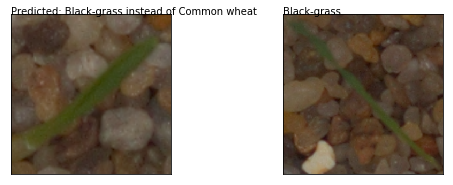

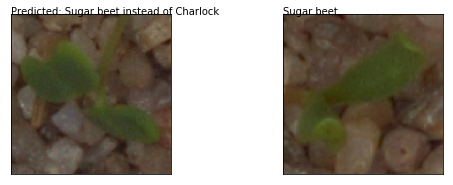

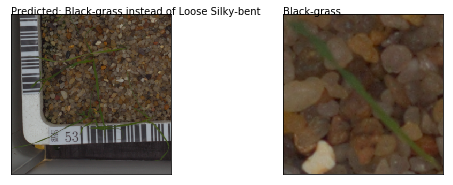

In [40]:
from matplotlib import pyplot as plt

correct_values = {}
for i in range(40):  
    true_value = np.argmax(valid_targets[i])
    if plant_predictions[i] != true_value:
        if plant_predictions[i] not in correct_values.keys():
            continue
        fig = plt.figure(figsize=(6, 6))  # figure size in inches
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.02, wspace=0.7)
        
        ax = fig.add_subplot(2, 2, 1, xticks=[], yticks=[])
        ax.imshow(valid_tensors[i], cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        ax.text(0, 0, "Predicted: %s instead of %s"% (plant_names[plant_predictions[i]], plant_names[true_value]))
        
        bx = fig.add_subplot(2, 2, 2, xticks=[], yticks=[])
        bx.imshow(correct_values[plant_predictions[i]], cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        bx.text(0, 0, plant_names[plant_predictions[i]])
    else:
        if plant_predictions[i] not in correct_values.keys():
            correct_values[plant_predictions[i]] = valid_tensors[i]

### Visual representation of the predicted values for the validation dataset by the final model

In [17]:
from collections import Counter
count = Counter(plant_predictions)
breed_count = {}
for i in range(len(plant_names)):
    breed_count[plant_names[i]] = count[i]

In [22]:
breed_count

{'Black-grass': 80,
 'Charlock': 78,
 'Cleavers': 54,
 'Common Chickweed': 117,
 'Common wheat': 44,
 'Fat Hen': 97,
 'Loose Silky-bent': 103,
 'Maize': 47,
 'Scentless Mayweed': 102,
 'Shepherds Purse': 53,
 'Small-flowered Cranesbill': 97,
 'Sugar beet': 77}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

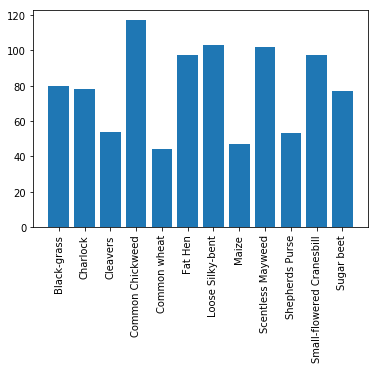

In [24]:
plt.bar(breed_count.keys(), breed_count.values())
plt.xticks(rotation=90)

### Conclusion
In conclusion, the xception model performed better than the inceptionresNetV2 model. A batch size of 64 also performed better than a batch size of 32. Lastly, the rmsprop optimizer performed better than the adam optimizer